## Classification Problem: Bank Customer Churn Prediction

The customer churn, also known as customer attrition, refers to the phenomenon whereby a customer leaves a company. There are [several studies](https://link.springer.com/article/10.1057/palgrave.jt.5740142) showing that acquiring new customers can cost five times more than satisfying and retaining existing customers. Therefore, it is important to track and retain the existing customers to save on marketing costs.

We will be predicting whether the bank's customer will leave the bank or not based on the customers' personal information and past history with the bank. We will be using the [Bank Customer Churn Data](https://www.kaggle.com/datasets/shantanudhakadd/bank-customer-churn-prediction) downloaded from Kaggle. As the data has clearly classified the customers into two distinct categories, exited the bank or didn't exit the bank, we will be performing supervised machine learning on a binary classification problem. 

## Objective

+ Build 3 Supervised Machine Learning Models to solve this classification problem
+ Determine the best model among the 3 Machine Learning methods for the bank to deploy
+ Use the best model to make predictions

## Steps

1. Data Cleaning. Perform train-test split
2. Build 3 Supervised Machine Learning models, Fine-tune model hyper-parameters using Grid Search CV
3. Model Evaluation and Recommendation


In [175]:
# Import required packages
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn import linear_model, neighbors, tree, svm, ensemble
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score, cross_validate

## Data Cleaning. Perform train-test split

In [176]:
bank_churn = pd.read_csv('bank_churn.csv')
bank_churn.dropna()
bank_churn.head()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


In [177]:
bank_churn["Exited"].value_counts()

Exited
0    7963
1    2037
Name: count, dtype: int64

In [178]:
bank_churn.dtypes

RowNumber            int64
CustomerId           int64
Surname             object
CreditScore          int64
Geography           object
Gender              object
Age                  int64
Tenure               int64
Balance            float64
NumOfProducts        int64
HasCrCard            int64
IsActiveMember       int64
EstimatedSalary    float64
Exited               int64
dtype: object

In [179]:
bank_churn.dropna()

,RowNumber,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,9996,15606229,Obijiaku,771,France,Male,39,5,0.00,2,1,0,96270.64,0
9996,9997,15569892,Johnstone,516,France,Male,35,10,57369.61,1,1,1,101699.77,0
9997,9998,15584532,Liu,709,France,Female,36,7,0.00,1,0,1,42085.58,1
9998,9999,15682355,Sabbatini,772,Germany,Male,42,3,75075.31,2,1,0,92888.52,1


In [180]:
bank_churn.shape
# 10,000 samples

(10000, 14)

In [181]:
# Data cleaning
# Drop columns that do not contribute to the model
bank = bank_churn.drop(["CustomerId", "Surname"], axis = 1)

# Encode the nominal categorical data into numbers
bank_cat = bank.select_dtypes(['object']).copy()
for col in bank_cat:
    print(col, ':')
    codes, uniques = pd.factorize(bank_cat[col], sort=True)
    bank[col]=codes
    print(uniques)

Geography :
Index(['France', 'Germany', 'Spain'], dtype='object')
Gender :
Index(['Female', 'Male'], dtype='object')


In [182]:
bank.head()
# where France, Germany and Spain are represented by 0, 1, 2 respectively
# where Female and Male are represented by 0, 1 respectively

,RowNumber,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Exited
0,1,619,0,0,42,2,0.00,1,1,1,101348.88,1
1,2,608,2,0,41,1,83807.86,1,0,1,112542.58,0
2,3,502,0,0,42,8,159660.80,3,1,0,113931.57,1
3,4,699,0,0,39,1,0.00,2,0,0,93826.63,0
4,5,850,2,0,43,2,125510.82,1,1,1,79084.10,0


In [183]:
# Separate data into training and test set

# Set "Exited" as model output and the rest features as model inputs
y = bank['Exited']
X = bank.drop(['Exited'], axis=1)

# Split the data into training and testing data, 80-20 train test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=2)

# Scaling the data into a smaller range (-3 to +3)
mean = X_train.mean()
std = X_train.std()

X_train = (X_train - mean) / std
X_test = (X_test - mean) / std

## Build 3 Supervised Machine Learning models. Fine-tune model hyper-parameters using Grid Search CV

### First Model: KNN

In [184]:
# K Nearest Neighbours Model

# Our baseline model starts with k = 3 as k = 1 could be noisy or subject to the effects of outliers
knn_clf = neighbors.KNeighborsClassifier(n_neighbors=3)
knn_clf.fit(X_train, y_train)

print('Baseline train_acc:', knn_clf.score(X_train, y_train),
      '\n Baseline test_acc:', knn_clf.score(X_test, y_test))


Baseline train_acc: 0.9 
 Baseline test_acc: 0.814


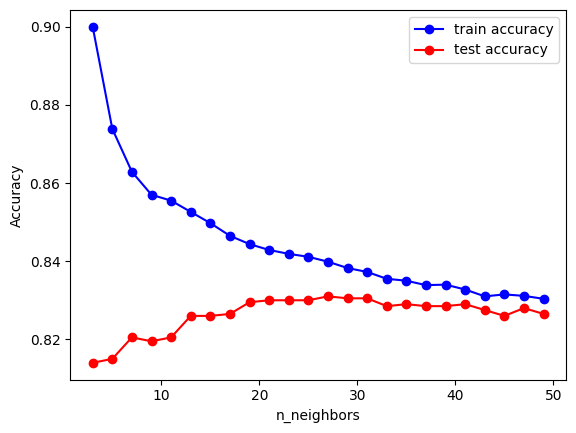

In [185]:
# Find the best n_neighbors that gives us the best training and testing accuracy

train_accuracy = []
test_accuracy = []

neighbors_settings = range(3, 50, 2) # from 3 to 30 with step 2 (only set K as odd numbers for this binary classification task)
for n_neighbors in neighbors_settings:
    # build the model
    knn_clf = neighbors.KNeighborsClassifier(n_neighbors=n_neighbors)
    knn_clf.fit(X_train, y_train)
    # record train accuracy
    train_accuracy.append(knn_clf.score(X_train, y_train))
    # record test accuracy
    test_accuracy.append(knn_clf.score(X_test, y_test))

plt.plot(neighbors_settings, train_accuracy, 'bo-', label="train accuracy")
plt.plot(neighbors_settings, test_accuracy, 'ro-', label="test accuracy")
plt.ylabel("Accuracy")
plt.xlabel("n_neighbors")
plt.legend()


In [186]:
# Find the best K value
3+np.argmax(test_accuracy)*2

27

In [187]:
# Model A: K value of 27

knn_clf = neighbors.KNeighborsClassifier(n_neighbors=27)
knn_clf.fit(X_train, y_train)

knnA_train_acc = knn_clf.score(X_train, y_train)
knnA_test_acc = knn_clf.score(X_test, y_test)

print('Model A train_acc:', knnA_train_acc,
      '\nModel A test_acc:', knnA_test_acc)

Model A train_acc: 0.839875 
Model A test_acc: 0.831


In [188]:
# Use GridSearch to optimise other parameters

# Create a KNN classifier
knn = neighbors.KNeighborsClassifier()

# Define the hyperparameter grid
# With the previously found best value k value of 27, set the range of k values to be close to 27 to account for possible shift in 'sweet spot' while tuning the other parameters
param_grid = {
    'n_neighbors': [21,23,25,27,29,31,33],
    'weights': ['uniform', 'distance'],
    'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']
}

# Create a GridSearchCV object, cv = 5 has we have a 80-20 train test split
knn_gscv = GridSearchCV(knn, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
knn_gscv.fit(X_train, y_train)

# Get the best hyperparameters
knn_best_params = knn_gscv.best_params_
print("Best Hyperparameters:", knn_best_params)

# Model with the best hyperparameters 
knn_GSCV_model = knn_gscv.best_estimator_

# Evaluate the model with the best hyperparameters on the train set and test set
knn_train_acc = knn_GSCV_model.score(X_train, y_train)
knn_test_acc = knn_GSCV_model.score(X_test, y_test)

# Model B 
print('Model B train_acc:', knn_train_acc,
      '\nModel B test_acc:', knn_test_acc)

Best Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 23, 'weights': 'distance'}
Model B train_acc: 1.0 
Model B test_acc: 0.828


### Best KNN Model

#### Model A - Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 27, 'weights': 'uniform'}
train_acc: 0.839875 
test_acc: 0.831

#### Model B - Hyperparameters: {'algorithm': 'auto', 'n_neighbors': 23, 'weights': 'distance'}
train_acc: 1.0
test_acc: 0.828

#### Conclusion: Model A is the best KNN Model.
Model A slightly edges out Model B in terms of testing accuracy, and the training accuracy of Model B is equal to 1, indicating that Model B is overfitting and too complex. Even though Model B is derived using 5-fold cross validation, and returns the model with the best average testing accuracy for the selected parameters, it may exhibit high variability when coming across different datasets in the future due to its extremely low bias as its training accuracy is equal to 1.

### Second Model: Decision Tree

Baseline train_acc: 0.83975 
Baseline test_acc: 0.8405


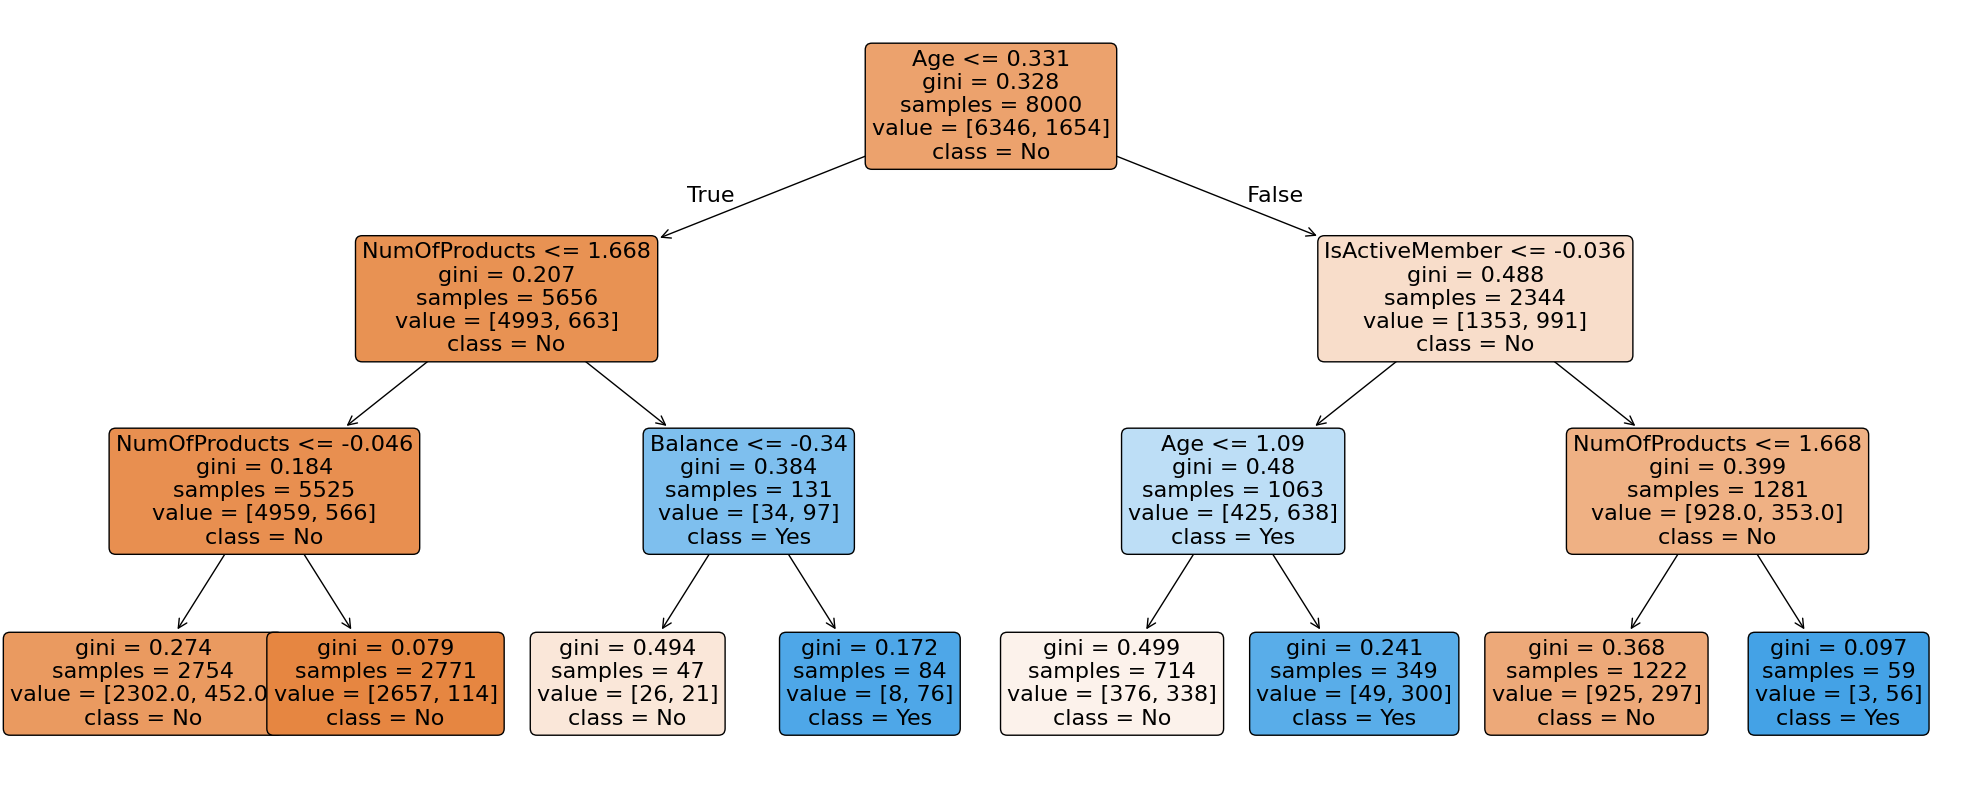

In [189]:
# Decision Tree

# Our baseline model starts with max_depth = 3

dt_clf = tree.DecisionTreeClassifier(max_depth = 3)
dt_clf.fit(X_train, y_train)
print('Baseline train_acc:', dt_clf.score(X_train, y_train),
      '\nBaseline test_acc:', dt_clf.score(X_test, y_test))

# Print out our decision tree, how the samples is split according to which criteria and the gini impurity
plt.figure(figsize=(25,10))
tree.plot_tree(dt_clf,
               feature_names = X_train.columns,
               class_names = ['No', 'Yes'],
               rounded = True,
               filled= True,
               fontsize =16)
plt.show()

In [190]:
# Find the best hyperparameters individually first that improves decision tree accuracy, followed by using GridSearchCV around the best values of the hyperparameters

# Find best max_depth (maximum depth of the tree) from range 2 to 50
depth_range = range(2,50)
train_accuracy_depth = []
test_accuracy_depth = []

for d in depth_range:
    dt_clf = tree.DecisionTreeClassifier(max_depth=d)
    dt_clf.fit(X_train, y_train)
    train_accuracy_depth.append(dt_clf.score(X_train, y_train))
    test_accuracy_depth.append(dt_clf.score(X_test, y_test))

print("The best max depth is", 2+np.argmax(test_accuracy_depth))

The best max depth is 5


In [191]:
# Find the best min_samples_leaf (The minimum number of samples required to be at a leaf node) from range 2 to 50
leaf_range = range(2,50)
train_accuracy_samples_leaf = []
test_accuracy_samples_leaf = []

for d in leaf_range:
    dt_clf = tree.DecisionTreeClassifier(min_samples_leaf=d)
    dt_clf.fit(X_train, y_train)
    train_accuracy_samples_leaf.append(dt_clf.score(X_train, y_train))
    test_accuracy_samples_leaf.append(dt_clf.score(X_test, y_test))

print("The best min samples leaf is", 2+np.argmax(test_accuracy_samples_leaf))

The best min samples leaf is 35


In [192]:
# Find the best min_samples_split (The minimum number of samples required to split an internal node) in the range of 50
split_range = range(2,500)
train_accuracy_samples_split = []
test_accuracy_samples_split = []

for d in split_range:
    dt_clf = tree.DecisionTreeClassifier(min_samples_split=d)
    dt_clf.fit(X_train, y_train)
    train_accuracy_samples_split.append(dt_clf.score(X_train, y_train))
    test_accuracy_samples_split.append(dt_clf.score(X_test, y_test))

print("The best min samples split is", 2+np.argmax(test_accuracy_samples_split))

The best min samples split is 269


In [193]:
#Decision Tree Model A using the best hyperparameters from previous step.
dt_clf = tree.DecisionTreeClassifier(criterion ='gini',
                                     max_depth = 5,
                                     min_samples_leaf = 33,
                                     min_samples_split = 269
                                    )
dt_clf.fit(X_train, y_train)

dt_train_acc = dt_clf.score(X_train, y_train)
dt_test_acc = dt_clf.score(X_test, y_test)

print('Model A train_acc:', dt_train_acc,
      '\nModel A test_acc:', dt_test_acc)

# Both the training and testing accuracy has improved using max_depth = 5, min_sample_leaf = 33 and
# min_samples_split = 45 in comparison to the default model.

Model A train_acc: 0.85525 
Model A test_acc: 0.855


In [194]:
# Create a Decision Tree classifier
dt = tree.DecisionTreeClassifier()

# Define the hyperparameter grid
# With the previously found best value of max_depth, min_samples_leaf and  min_samples_split, set the range of values to be close to their best values to account for possible shift in 'sweet spot' while tuning the other parameters

param_grid = {'min_samples_leaf': [33, 34, 35, 36, 37],
              'min_samples_split': [267, 268, 269, 270, 271],
              'max_depth' : [3, 4, 5, 6, 7],
              'criterion' :['gini', 'entropy']
             }

# Create a GridSearchCV object, cv = 5 has we have a 80-20 train test split
dt_gscv = GridSearchCV(dt, param_grid, cv=5, scoring='accuracy')

# Fit the model to the data
dt_gscv.fit(X_train, y_train)

# Get the best hyperparameters
dt_best_params = dt_gscv.best_params_
print("Best Hyperparameters:", dt_best_params)

# Model with the best hyperparameters 
dt_GSCV_model = dt_gscv.best_estimator_

# Evaluate the model with the best hyperparameters on the train set and test set
dt_train_acc = dt_GSCV_model.score(X_train, y_train)
dt_test_acc = dt_GSCV_model.score(X_test, y_test)

# Model B
print('Model B train_acc:', dt_train_acc,
      '\nModel B test_acc:', dt_test_acc)

Best Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 33, 'min_samples_split': 267}
Model B train_acc: 0.85525 
Model B test_acc: 0.855


### Best Decision Tree Model

#### Model A - Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 33, 'min_samples_split': 269}
train_acc: 0.85525 
test_acc: 0.855

#### Model B - Hyperparameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 33, 'min_samples_split': 267}
train_acc: 0.85525
test_acc: 0.855

#### Conclusion: Model B is the best Decision Tree Model.
Model A and B has the exact same training and testing accuracy. Because Model B is derived using 5-fold cross validation, it is chosen as the better Decision Tree model as it is more representative of the data due to being trained from different blocks of data. 

### Third Model: Logistic Regression

In [195]:
# Logistic Regression Model

# Our baseline model starts with the default solver lbfgs
lg_clf = linear_model.LogisticRegression(solver = 'lbfgs')
# Fit the model to the training set
lg_clf.fit(X_train,y_train)

# Print out the model coefficients and intercept
print(lg_clf.coef_)
print(lg_clf.intercept_, '\n')

# Compare the training accuracy to the testing accuracy
print('Logistic Regression train_acc:', lg_clf.score(X_train, y_train))
print('Logistic Regression test_acc:', lg_clf.score(X_test, y_test))

[[-0.04042501 -0.081015    0.07095002 -0.29013496  0.76802473 -0.05514052
   0.29511087 -0.02575606 -0.02077008 -0.51951231  0.046125  ]]
[-1.61099108] 

Logistic Regression train_acc: 0.806375
Logistic Regression test_acc: 0.813


In [196]:
# We attempt to improve the model accuracy by tuning the logistic regression model hyperparameters using GridSearch CV

# We tune the hyperparameters "solver" and "max_iter"

lg = linear_model.LogisticRegression()

param_grid = {"solver" : ['lbfgs', 'liblinear', 'newton-cg', 'newton-cholesky', 'sag', 'saga'],
              'max_iter' : [60, 80, 100, 120, 140]}

lg_gscv = GridSearchCV(lg, param_grid=param_grid, scoring='accuracy', cv= 5, n_jobs=-1)
# cv: number of partitions for cross validation
# n_jobs: number of jobs to run in parallel, -1 means using all processors

lg_gscv.fit(X_train, y_train)

# Get the best hyperparameters
lg_best_params = lg_gscv.best_params_
print("Best Hyperparameters:", lg_best_params)

# Model with the best hyperparameters 
lg_GSCV_model = lg_gscv.best_estimator_

# Evaluate the model with the best hyperparameters on the train set and test set
lg_train_acc = lg_GSCV_model.score(X_train, y_train)
lg_test_acc = lg_GSCV_model.score(X_test, y_test)

# Model B
print('Model B train_acc:', lg_train_acc,
      '\nModel B test_acc:', lg_test_acc)

Best Hyperparameters: {'max_iter': 60, 'solver': 'lbfgs'}
Model B train_acc: 0.806375 
Model B test_acc: 0.813


### Model Evaluation and Recommendation

<Axes: title={'center': 'Train & Test Accuracy for different models'}>

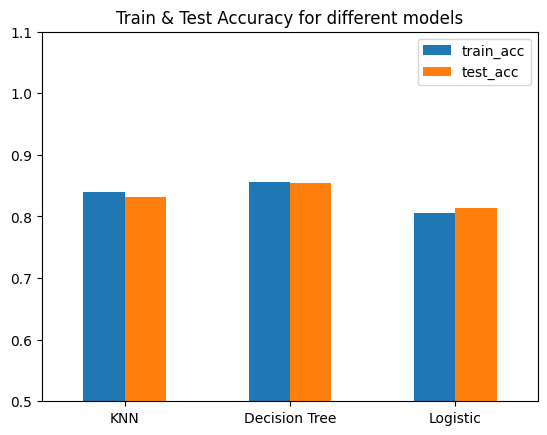

In [197]:
# Comparison
train_acc = [knnA_train_acc, dt_train_acc, lg_train_acc]
test_acc =[knnA_test_acc, dt_test_acc, lg_test_acc]
label =['KNN', 'Decision Tree', 'Logistic']

df_acc = pd.DataFrame({'train_acc': train_acc,
                   'test_acc': test_acc}, index=label)
df_acc.plot.bar(rot=0, ylim=[0.5, 1.1], title ='Train & Test Accuracy for different models')

# The bar plot provides us with a good visualisation on how each model performed
# The decision tree model stands out as it has the highest training and testing accuracy.  
# Thus, we chose Decision Tree as our final model.

In [198]:
# Source code credit for this function: https://gist.github.com/shaypal5/94c53d765083101efc0240d776a23823
def print_confusion_matrix(confusion_matrix, class_names, figsize = (10,7), fontsize=14):
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('Truth')
    plt.xlabel('Prediction')

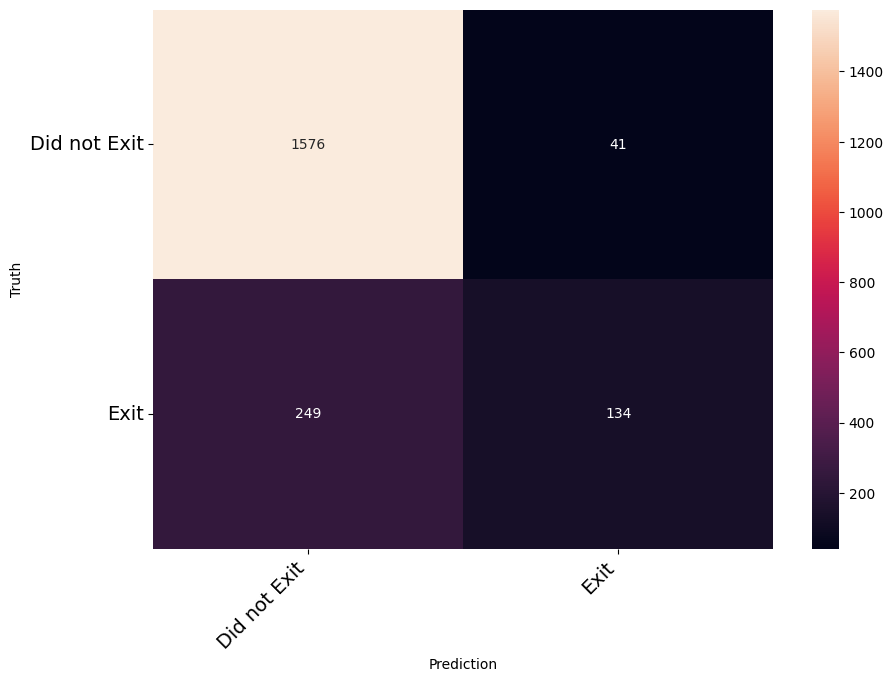

In [199]:
# We use our decision tree model to make prediction on test data
dt_GSCV_model.predict_proba(X_test)
y_pred = dt_GSCV_model.predict(X_test)

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
print_confusion_matrix(cm, ["Did not Exit", "Exit"])

Our confusion matrix indicates that our model accurately predicted that 1576 customers did not leave the bank and wrongly predicted that 41 customers did not left the bank. Our model also accurately predicted that 134 customers left the bank and wrongly predicted that 249 customers left the bank

In [200]:
# Classification Report
print(classification_report(y_test, y_pred))
# Precision = TP / (TP + FP)
# Recall = TP / (TP + FN)

              precision    recall  f1-score   support

           0       0.86      0.97      0.92      1617
           1       0.77      0.35      0.48       383

    accuracy                           0.85      2000
   macro avg       0.81      0.66      0.70      2000
weighted avg       0.84      0.85      0.83      2000



+ Of all the customers that were predicted to not exit the bank, our Decision Tree model accurately predicted 86% of them, while 14% of them did exit the bank. 
+ Of all the customers that **actually** did not exit the bank, our Decision Tree model accurately predicted that 97% of them did not exit the bank. 

+ Of all the customers that were predicted to exit the bank, our Decision Tree model accurately predicted it 77% of them, while 23% did not exit the bank. 
+ Of all the customers that **actually** exited the bank, our Decision Tree model accurately predicted that 35% of them exited the bank. 

### Conclusion

Our best model for the bank to deploy would be the Decision Tree model with these specific parameters: {'criterion': 'gini', 'max_depth': 5, 'min_samples_leaf': 33, 'min_samples_split': 267}
